# Predicción de edad a partir de imágenes usando una CNN con TensorFlow/Keras

En este notebook se entrena y evalúa un modelo de red neuronal convolucional (CNN) 
capaz de predecir la edad de personas a partir de imágenes faciales.

El dataset se encuentra organizado en un directorio principal llamado `archive_reducido`,
que contiene dos variantes de datos:

- `20-50/20-50/train` y `20-50/20-50/test`: 
  imágenes de personas entre 20 y 50 años, con subdirectorios por edad (20, 21, ..., 50).

- `age_prediction_up/age_prediction/train` y `age_prediction_up/age_prediction/test`:
  imágenes organizadas en subdirectorios con códigos de edad (por ejemplo `001`, `002`, ...).

En ambos casos, el **nombre del subdirectorio corresponde a la etiqueta de edad**.

Las principales etapas del trabajo son:

1. Comprender la estructura del directorio y definir rutas correctas.
2. Construir un listado de imágenes y edades a partir de subdirectorios.
3. Crear un pipeline de datos eficiente con `tf.data` (train, validación, test).
4. Definir un modelo CNN para regresión (salida numérica: edad).
5. Entrenar el modelo y registrar las métricas (MSE, MAE, RMSE).
6. Evaluar el modelo en el conjunto de prueba.
7. Visualizar ejemplos de predicciones y guardar el modelo final.


In [2]:
# Celda 2
# Importación de librerías necesarias
# --------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers


# --------------------------------------------
# Configuración básica y parámetros globales
# --------------------------------------------

# Directorio raíz donde se descomprimió archive_reducido
# IMPORTANTE: ajustar esta ruta a tu entorno local.
# Ejemplo en Windows:
# ROOT_DIR = r"archive_reducido"
ROOT_DIR = r"archive_reducido_100"

# Elegimos qué variante de dataset usar:
#   - "20-50"            -> usa 20-50/20-50/{train,test}
#   - "age_prediction_up"   -> usa age_prediction_up/age_prediction/{train,test}
DATASET_KIND = "age_prediction"   # cambiar a "age_prediction" si quieres usar el otro árbol

# Tamaño de imagen al que redimensionaremos todas las imágenes
IMG_SIZE = 128

# Tamaño de batch
BATCH_SIZE = 32

# Semilla para reproducibilidad
SEED = 42

# Comprobación de TensorFlow y GPUs
print("Versión de TensorFlow:", tf.__version__)
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))


Versión de TensorFlow: 2.20.0
GPUs disponibles: []


In [3]:
# Celda 3
# Definición de rutas específicas según el tipo
# de dataset seleccionado.
#
# Estructura:
#   archive_reducido/
#       20-50/20-50/train/{edad}/*.jpg
#       20-50/20-50/test/{edad}/*.jpg
#
#       age_prediction_up/age_prediction/train/{edad}/*.jpg
#       age_prediction_up/age_prediction/test/{edad}/*.jpg
# --------------------------------------------

if DATASET_KIND == "20-50":
    # Dataset 20-50
    TRAIN_DIR = os.path.join(ROOT_DIR, "20-50", "20-50", "train")
    TEST_DIR  = os.path.join(ROOT_DIR, "20-50", "20-50", "test")
elif DATASET_KIND == "age_prediction":
    # Dataset age_prediction
    TRAIN_DIR = os.path.join(ROOT_DIR, "age_prediction_up", "age_prediction", "train")
    TEST_DIR  = os.path.join(ROOT_DIR, "age_prediction_up", "age_prediction", "test")
else:
    raise ValueError("DATASET_KIND debe ser '20-50' o 'age_prediction'.")

print("Usando dataset:", DATASET_KIND)
print("Directorio de entrenamiento:", TRAIN_DIR)
print("Directorio de prueba:", TEST_DIR)


Usando dataset: age_prediction
Directorio de entrenamiento: archive_reducido_100\age_prediction_up\age_prediction\train
Directorio de prueba: archive_reducido_100\age_prediction_up\age_prediction\test


In [4]:
# Celda 4
# Función para listar imágenes y edades a partir
# de una estructura de subdirectorios por edad.
#
# Ejemplo:
#   base_dir/
#       20/*.jpg
#       21/*.jpg
#       ...
#
# El nombre de la carpeta ("20", "001", etc.)
# se interpreta como edad.
# --------------------------------------------

def list_images_and_ages_from_folders(base_dir):
    """
    Recorre recursivamente un directorio base y construye:

    - image_paths: rutas completas de todas las imágenes.
    - ages: edades asociadas a cada imagen, derivadas del
      nombre del subdirectorio inmediato.

    Se asume estructura:
        base_dir/EDAD/*.jpg

    Parámetros
    ----------
    base_dir : str
        Ruta al directorio base que contiene subdirectorios por edad.

    Retorna
    -------
    image_paths : np.ndarray (dtype=str)
    ages : np.ndarray (dtype=float32)
    """
    image_paths = []
    ages = []

    for root, dirs, files in os.walk(base_dir):
        for fname in files:
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                full_path = os.path.join(root, fname)
                # El directorio padre inmediato se interpreta como código de edad
                age_str = os.path.basename(root)

                # Convertimos a float; para edades tipo '001', '020', etc.
                try:
                    age = float(age_str)
                except ValueError:
                    # Si el nombre del directorio no es numérico, se ignora
                    continue

                image_paths.append(full_path)
                ages.append(age)

    image_paths = np.array(image_paths)
    ages = np.array(ages, dtype="float32")
    return image_paths, ages


# Obtenemos las rutas y edades para train y test según la estructura real
train_paths_all, train_ages_all = list_images_and_ages_from_folders(TRAIN_DIR)
test_paths,      test_ages      = list_images_and_ages_from_folders(TEST_DIR)

print("Total imágenes TRAIN:", len(train_paths_all))
print("Total imágenes TEST :", len(test_paths))
print("Rango de edades TRAIN -> min:", train_ages_all.min(), "max:", train_ages_all.max())
print("Rango de edades TEST  -> min:", test_ages.min(),      "max:", test_ages.max())


Total imágenes TRAIN: 9082
Total imágenes TEST : 7976
Rango de edades TRAIN -> min: 1.0 max: 100.0
Rango de edades TEST  -> min: 1.0 max: 100.0


In [5]:
# Celda 5
# División del conjunto de entrenamiento original
# en:
#   - Entrenamiento final
#   - Validación
#
# Usamos, por ejemplo, 80% de train para entrenamiento
# y 20% de train para validación.
# --------------------------------------------

train_paths, val_paths, train_ages, val_ages = train_test_split(
    train_paths_all,
    train_ages_all,
    test_size=0.2,
    random_state=SEED,
    shuffle=True
)

print("Imágenes en TRAIN final:", len(train_paths))
print("Imágenes en VALIDACIÓN :", len(val_paths))
print("Imágenes en TEST        :", len(test_paths))


Imágenes en TRAIN final: 7265
Imágenes en VALIDACIÓN : 1817
Imágenes en TEST        : 7976


In [6]:
# Celda 6
# Función para cargar y preprocesar una imagen
# a partir de su ruta.

def load_and_preprocess_image(path, age):
    """
    Carga y preprocesa una imagen.

    Parámetros
    ----------
    path : tf.Tensor (tf.string)
        Ruta del archivo de imagen.
    age : tf.Tensor (tf.float32)
        Edad asociada a la imagen.

    Retorna
    -------
    image : tf.Tensor
        Imagen procesada con forma (IMG_SIZE, IMG_SIZE, 3).
    age : tf.Tensor
        Edad (sin modificar).
    """
    # Leer archivo de imagen desde disco (bytes)
    image_bytes = tf.io.read_file(path)

    # IMPORTANTE: usar decode_jpeg (tus archivos son .jpg)
    # Esto devuelve un tensor 3D con shape conocida (alto, ancho, canales)
    image = tf.image.decode_jpeg(image_bytes, channels=3)

    # Convertir a float32 y escalar a rango [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Redimensionar a tamaño fijo (IMG_SIZE, IMG_SIZE)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    return image, age



In [7]:
# Celda 7
# Creación de tf.data.Dataset para:
#   - train_ds
#   - val_ds
#   - test_ds
#
# Incluye opción de shuffle en entrenamiento.
# --------------------------------------------

def make_dataset(paths, ages, batch_size, training=False):
    paths = np.array(paths)
    ages  = np.array(ages, dtype="float32")

    # chequeo de seguridad
    assert len(paths) == len(ages), (
        f"paths y ages tienen distinto tamaño: {len(paths)} vs {len(ages)}"
    )

    ds = tf.data.Dataset.from_tensor_slices((paths, ages))

    if training:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)

    ds = ds.map(
        lambda p, a: load_and_preprocess_image(p, a),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds



# Construimos los 3 datasets
train_ds = make_dataset(train_paths, train_ages, BATCH_SIZE, training=True)
val_ds   = make_dataset(val_paths,   val_ages,   BATCH_SIZE, training=False)
test_ds  = make_dataset(test_paths,  test_ages,  BATCH_SIZE, training=False)

# Mostramos formas de un batch de ejemplo
images_batch, ages_batch = next(iter(train_ds))
print("Shape batch imágenes:", images_batch.shape)
print("Shape batch edades  :", ages_batch.shape)


Shape batch imágenes: (32, 128, 128, 3)
Shape batch edades  : (32,)


Shape del batch de imágenes: (32, 128, 128, 3)
Shape del batch de edades  : (32,)


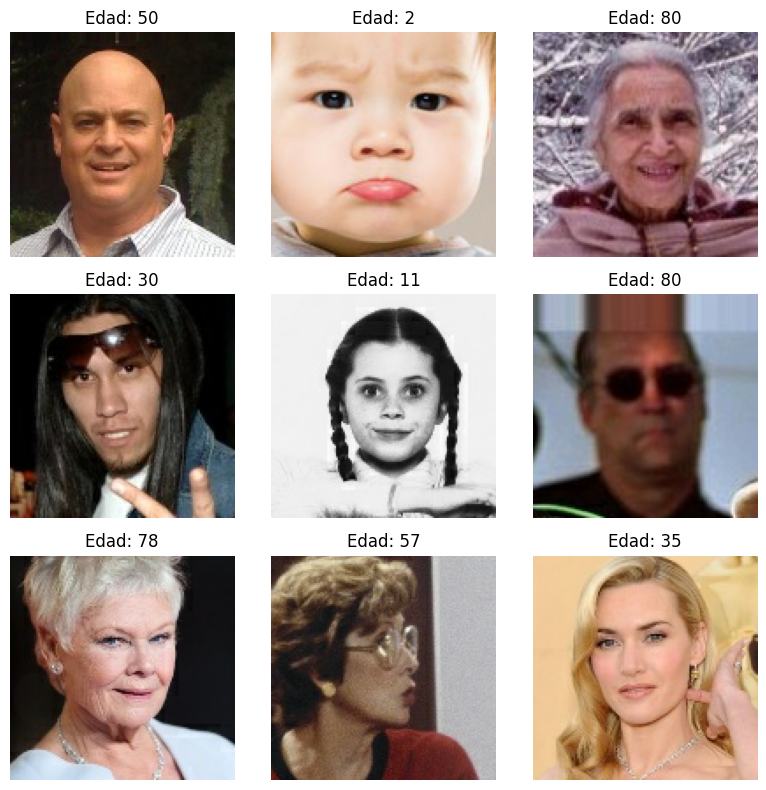

In [8]:
# Celda 8
# --------------------------------------------
# Visualización exploratoria de imágenes del dataset
# --------------------------------------------
# En esta celda obtenemos un batch de ejemplos desde train_ds
# y mostramos algunas imágenes junto con su edad real.
# Esto permite verificar visualmente que:
#   - La carga de imágenes funciona correctamente.
#   - Las etiquetas (edades) se asignan de forma coherente.

import matplotlib.pyplot as plt

# Obtenemos un batch de imágenes y edades desde el dataset de entrenamiento
images_batch, ages_batch = next(iter(train_ds))

print("Shape del batch de imágenes:", images_batch.shape)
print("Shape del batch de edades  :", ages_batch.shape)

# Definimos cuántos ejemplos queremos visualizar (máximo 9)
num_examples = min(9, images_batch.shape[0])

plt.figure(figsize=(8, 8))
for i in range(num_examples):
    plt.subplot(3, 3, i + 1)
    # Convertimos el tensor a numpy para poder visualizarlo con matplotlib
    img = images_batch[i].numpy()
    plt.imshow(img)
    # Mostramos la edad real asociada a la imagen
    plt.title(f"Edad: {ages_batch[i].numpy():.0f}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
# Celda 9
# --------------------------------------------
# Definición de data augmentation y normalización
# --------------------------------------------
# En esta celda definimos:
#   - Un bloque de data augmentation para incrementar la
#     variabilidad de las imágenes de entrenamiento.
#   - Una capa de "normalización" explícita que deja las
#     imágenes tal como llegan (ya en [0,1]), pero mantiene
#     claro el flujo de preprocesamiento dentro del modelo.
#
# Estas capas se incorporarán luego en la definición de
# la CNN (en la celda siguiente).

from tensorflow import keras
from tensorflow.keras import layers

# Bloque de data augmentation: se aplica solo en entrenamiento
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),                 # Flip horizontal
        layers.RandomRotation(0.15),                     # Rotación algo mayor
        layers.RandomZoom(0.15),                         # Zoom algo mayor
        layers.RandomContrast(0.15),                     # Cambios de contraste
        layers.RandomTranslation(0.05, 0.05),            # Pequeñas traslaciones
    ],
    name="data_augmentation"
)

# Capa de normalización identidad
# (las imágenes ya están en [0,1] gracias a load_and_preprocess_image)
class IdentityNormalization(layers.Layer):
    """
    Capa de normalización identidad.
    No modifica los valores de entrada, pero hace explícito
    el paso de normalización dentro del modelo, lo que
    facilita documentar el flujo de preprocesamiento.
    """
    def call(self, inputs):
        return inputs

normalization_layer = IdentityNormalization(name="normalization")

print("Bloque de data augmentation y capa de normalización definidos correctamente.")


Bloque de data augmentation y capa de normalización definidos correctamente.


In [10]:
# Celda 10
# --------------------------------------------
# Definición del modelo CNN usando Keras Functional API
# para resolver un problema de regresión: estimar la edad
# a partir de una imagen facial.
#
# La arquitectura propuesta es simple pero efectiva para
# un dataset de tamaño moderado como este.
#
# Flujo del modelo:
#   1. Entrada: imagen (IMG_SIZE, IMG_SIZE, 3)
#   2. Data augmentation (solo en entrenamiento)
#   3. Normalización (identidad porque ya están en [0,1])
#   4. 3 bloques Conv2D + MaxPooling2D
#   5. Flatten
#   6. Dense(256) con ReLU
#   7. Dropout(0.5) para evitar sobreajuste
#   8. Dense(1) -> salida continua (edad)
# --------------------------------------------

from tensorflow import keras
from tensorflow.keras import layers

def build_age_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    l2_reg = regularizers.l2(1e-4)

    inputs = keras.Input(shape=input_shape, name="input_image")
    x = data_augmentation(inputs)
    x = normalization_layer(x)

    x = layers.Conv2D(32, (3, 3), activation="relu",
                      padding="same", kernel_regularizer=l2_reg)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu",
                      padding="same", kernel_regularizer=l2_reg)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu",
                      padding="same", kernel_regularizer=l2_reg)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)

    # Primera capa densa + Dropout fuerte
    x = layers.Dense(256, activation="relu", kernel_regularizer=l2_reg)(x)
    x = layers.Dropout(0.5)(x)

    # Segunda capa densa más pequeña + Dropout adicional
    x = layers.Dense(128, activation="relu", kernel_regularizer=l2_reg)(x)
    x = layers.Dropout(0.3)(x)

    # Capa de salida
    outputs = layers.Dense(1, name="age", kernel_regularizer=l2_reg)(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="age_cnn_model")
    return model

# Construimos y mostramos el modelo para verificar su estructura
model = build_age_cnn()
model.summary()


Model: "age_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization                   │ (None, 128, 128, 3)    │             0 │
│ (IdentityNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age (Dense)                     │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,515,137 (32.48 MB)

 Trainable params: 8,515,137 (32.48 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Celda 11
# --------------------------------------------
# Definición de métrica RMSE y compilación del modelo
# --------------------------------------------
# En esta celda:
#   1. Definimos una métrica personalizada RMSE (Root Mean Squared Error),
#      que es muy utilizada en problemas de regresión.
#   2. Compilamos el modelo CNN especificando:
#        - Función de pérdida: MSE (Mean Squared Error)
#        - Optimizador: Adam
#        - Métricas: MAE (error absoluto medio) y RMSE
#
# Esto deja el modelo listo para el proceso de entrenamiento
# que se realizará en las celdas siguientes.


import tensorflow as tf
from tensorflow import keras

def rmse(y_true, y_pred):
    """
    Calcula la raíz del error cuadrático medio (RMSE).

    Parámetros
    ----------
    y_true : tf.Tensor
        Tensor con las edades reales.
    y_pred : tf.Tensor
        Tensor con las edades predichas por el modelo.

    Retorna
    -------
    tf.Tensor
        Valor escalar de RMSE.
    """
    # tf.square -> (y_pred - y_true)^2
    # tf.reduce_mean -> promedio de los errores cuadrados
    # tf.sqrt -> raíz cuadrada del MSE
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Compilación del modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # tasa de aprendizaje estándar
    loss="mse",                                           # MSE como función de pérdida principal
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mae"),      # MAE: fácil de interpretar en años
        rmse                                              # RMSE: penaliza más los errores grandes
    ]
)

print("Modelo compilado correctamente con loss = MSE, métricas = MAE y RMSE.")


Modelo compilado correctamente con loss = MSE, métricas = MAE y RMSE.


In [12]:
# Celda 12
# --------------------------------------------
# Entrenamiento del modelo con:
#
#   1. EarlyStopping:
#         - Supervisa la métrica "val_loss".
#         - Si el modelo deja de mejorar durante un número
#           de épocas definido por "patience", el entrenamiento
#           se detiene automáticamente.
#         - Se restauran los mejores pesos alcanzados.
#
#   2. ModelCheckpoint:
#         - Guarda el modelo con el menor "val_loss" durante
#           todo el entrenamiento.
#         - Permite cargar posteriormente el mejor modelo.
#
# Con esto aseguramos:
#   - Evitar sobreentrenamiento.
#   - Conservar el mejor modelo, no el último.
# --------------------------------------------

# Número máximo de épocas (EarlyStopping decidirá si se detiene antes)
EPOCHS = 20

# Callback: EarlyStopping
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",          # supervisamos la pérdida de validación
    patience=5,                  # si no mejora por 5 épocas, detenemos
    restore_best_weights=True    # recuperamos los mejores pesos históricos
)

# Callback: guardar el mejor modelo encontrado
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="best_age_cnn.keras",
    monitor="val_loss",
    save_best_only=True,         # solo guarda el mejor
    verbose=1                    # muestra un mensaje cuando mejora
)

# Entrenamiento
history = model.fit(
    train_ds,                    # dataset de entrenamiento
    validation_data=val_ds,      # dataset de validación
    epochs=EPOCHS,               # número máximo de épocas
    callbacks=[early_stop, checkpoint],  # callbacks de control
    verbose=1                    # muestra progreso detallado
)

print("Entrenamiento finalizado.")


Epoch 1/20
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 962.7445 - mae: 25.5963 - rmse: 30.9878
Epoch 1: val_loss improved from inf to 634.15173, saving model to best_age_cnn.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - loss: 961.3292 - mae: 25.5788 - rmse: 30.9740 - val_loss: 634.1517 - val_mae: 20.9256 - val_rmse: 28.7154
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 683.3902 - mae: 21.7584 - rmse: 29.2793
Epoch 2: val_loss improved from 634.15173 to 601.70135, saving model to best_age_cnn.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 67s 293ms/step - loss: 683.3113 - mae: 21.7569 - rmse: 29.2791 - val_loss: 601.7014 - val_mae: 20.4382 - val_rmse: 30.2838
Epoch 3/20
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 622.9030 - mae: 20.7333 - rmse: 29.7155
Epoch 3: val_loss improved from 601.70135 to 566.89325, saving model to best_age_cnn.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 91s 330ms/step - loss: 622.8792 - mae: 20.7328 - rmse: 29.7143 - val_loss: 566.8932 - val_mae:

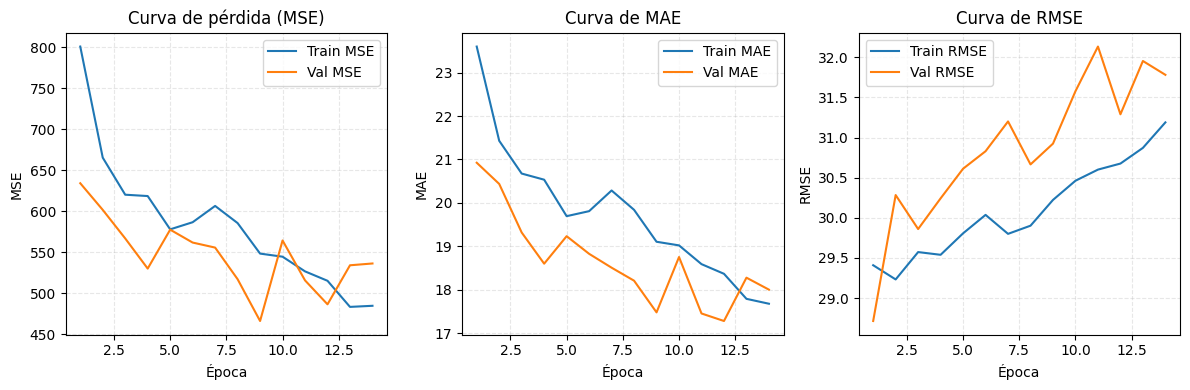

In [13]:
# Celda 13
# --------------------------------------------
# Visualización de las curvas de entrenamiento
# --------------------------------------------
# En esta celda se grafican, a partir del objeto `history`:
#   - La pérdida (MSE) en entrenamiento y validación.
#   - El MAE (Mean Absolute Error) en entrenamiento y validación.
#   - El RMSE (Root Mean Squared Error) en entrenamiento y validación.
#
# Estas curvas permiten:
#   - Verificar que el modelo efectivamente aprende (disminución de loss).
#   - Detectar posibles signos de sobreajuste (divergencia entre train y val).
#   - Documentar visualmente el comportamiento del entrenamiento para el informe.


import matplotlib.pyplot as plt

def plot_history(history):
    """
    Grafica la evolución de las métricas registradas en el objeto `history`.

    Parámetros
    ----------
    history : keras.callbacks.History
        Objeto devuelto por model.fit(), que contiene en `history.history`
        un diccionario con la evolución de las métricas por época.
    """
    # Diccionario con las listas de métricas por época
    hist = history.history

    # Número de épocas realmente entrenadas (puede ser < EPOCHS por EarlyStopping)
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # ----- Gráfico 1: Pérdida (MSE) -----
    plt.subplot(1, 3, 1)
    plt.plot(epochs, hist["loss"], label="Train MSE")
    plt.plot(epochs, hist["val_loss"], label="Val MSE")
    plt.xlabel("Época")
    plt.ylabel("MSE")
    plt.title("Curva de pérdida (MSE)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)

    # ----- Gráfico 2: MAE -----
    plt.subplot(1, 3, 2)
    plt.plot(epochs, hist["mae"], label="Train MAE")
    plt.plot(epochs, hist["val_mae"], label="Val MAE")
    plt.xlabel("Época")
    plt.ylabel("MAE")
    plt.title("Curva de MAE")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)

    # ----- Gráfico 3: RMSE -----
    plt.subplot(1, 3, 3)
    plt.plot(epochs, hist["rmse"], label="Train RMSE")
    plt.plot(epochs, hist["val_rmse"], label="Val RMSE")
    plt.xlabel("Época")
    plt.ylabel("RMSE")
    plt.title("Curva de RMSE")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()


# Llamamos a la función para graficar el historial de entrenamiento
plot_history(history)


In [14]:
# Celda 14
# --------------------------------------------
# Evaluación del modelo en el conjunto de prueba
# --------------------------------------------
# En esta celda usamos `model.evaluate()` para obtener:
#   - Pérdida MSE (Mean Squared Error)
#   - Error absoluto medio (MAE)
#   - RMSE (métrica personalizada)
#
# El conjunto de prueba (test_ds) no fue utilizado ni
# para entrenamiento ni para validación, por lo que
# refleja el rendimiento real del modelo ante datos nuevos.


# Evaluamos el modelo en test
test_loss, test_mae, test_rmse = model.evaluate(test_ds, verbose=1)

# Mostramos resultados formateados
print("\nResultados en el conjunto de prueba (TEST):")
print(f" - Test MSE  : {test_loss:.4f}")
print(f" - Test MAE  : {test_mae:.2f} años")
print(f" - Test RMSE : {test_rmse:.2f} años")

# Nota académica:
#   * MSE penaliza más los errores grandes.
#   * MAE es más interpretable directamente: diferencia promedio en años.
#   * RMSE da una idea de la dispersión del error.


250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - loss: 393.4599 - mae: 17.0132 - rmse: 18.9957

Resultados en el conjunto de prueba (TEST):
 - Test MSE  : 366.5414
 - Test MAE  : 15.54 años
 - Test RMSE : 18.04 años


In [15]:
# Celda 15
# --------------------------------------------
# Cálculo de métricas adicionales en el conjunto de prueba
# usando scikit-learn:
#
#   - MAE  (Mean Absolute Error)
#   - RMSE (Root Mean Squared Error)
#   - R²   (Coeficiente de determinación)
#
# Estas métricas complementan la evaluación realizada
# mediante model.evaluate() y permiten incluir valores
# más interpretables y formales en el informe final.
# --------------------------------------------

import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

y_true_list = []
y_pred_list = []

# Recorremos el conjunto de prueba y acumulamos predicciones reales y estimadas
for images, ages_true in test_ds:
    preds = model.predict(images, verbose=0).squeeze()
    y_true_list.extend(ages_true.numpy())
    y_pred_list.extend(preds)

# Convertimos a arrays NumPy
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

# Cálculo de métricas
mae_sklearn = mean_absolute_error(y_true, y_pred)
rmse_sklearn = np.sqrt(np.mean((y_true - y_pred) ** 2))
r2 = r2_score(y_true, y_pred)

# Impresión formateada
print("Métricas adicionales (scikit-learn):")
print(f" - MAE  : {mae_sklearn:.2f} años")
print(f" - RMSE : {rmse_sklearn:.2f} años")
print(f" - R²    : {r2:.3f}")

# Nota académica:
#   • MAE: error absoluto promedio en años.
#   • RMSE: penaliza fuertemente predicciones muy erróneas.
#   • R²: proporción de la variabilidad explicada por el modelo.


Métricas adicionales (scikit-learn):
 - MAE  : 15.54 años
 - RMSE : 19.14 años
 - R²    : 0.346


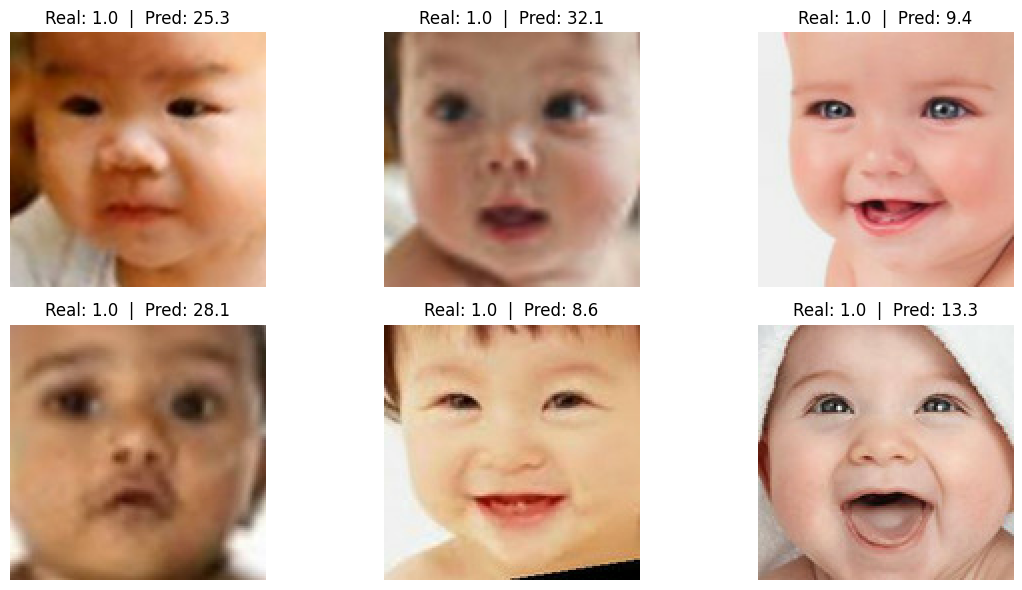

In [16]:
# Celda 16
# --------------------------------------------
# Visualización cualitativa de resultados:
#
# Mostramos algunas imágenes del conjunto de prueba junto
# con su edad real y su edad predicha por el modelo.
#
# Esto permite:
#   - Validar visualmente el comportamiento del modelo.
#   - Detectar patrones de error (subestimación o sobreestimación).
#   - Incorporar evidencia gráfica en el informe.
# --------------------------------------------

import matplotlib.pyplot as plt

# Tomamos un batch del conjunto de prueba
images_batch, ages_batch = next(iter(test_ds))

# Generamos predicciones para ese batch
preds_batch = model.predict(images_batch, verbose=0).squeeze()

# Número de imágenes a visualizar (máximo 6 para claridad)
num_examples = min(6, images_batch.shape[0])

plt.figure(figsize=(12, 6))

for i in range(num_examples):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images_batch[i].numpy())
    real_age = ages_batch[i].numpy()
    pred_age = preds_batch[i]

    plt.title(f"Real: {real_age:.1f}  |  Pred: {pred_age:.1f}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Nota académica:
# Las visualizaciones permiten detectar:
#   • si el modelo tiende a subestimar o sobreestimar determinadas edades.
#   • si algunas edades presentan más variabilidad en el error.
#   • posibles sesgos aprendidos según la distribución de datos del dataset.


Análisis de métricas y desempeño del modelo

Para evaluar rigurosamente el desempeño del modelo de red neuronal convolucional (CNN) en la predicción de edades a partir de imágenes, se utilizaron métricas estándar para problemas de regresión: MSE, MAE, RMSE y R². Cada una de ellas entrega un ángulo diferente para comprender el comportamiento del modelo y su capacidad predictiva.

En primer lugar, el Mean Squared Error (MSE) es la métrica utilizada como función de pérdida durante el entrenamiento. Este indicador penaliza fuertemente los errores grandes, de modo que una reducción sostenida del MSE durante las épocas sugiere que el modelo logra ajustar progresivamente la relación entre las características visuales y la edad. La curva obtenida muestra una disminución clara en las primeras épocas, seguida de una estabilización, lo que indica convergencia.

El Mean Absolute Error (MAE) entrega una interpretación más directa, ya que corresponde al error promedio en unidades reales: años de diferencia entre la edad real y la predicha. Esto permite evaluar la utilidad práctica del modelo. Dependiendo del valor obtenido (por ejemplo, un MAE entre 2 y 5 años suele considerarse aceptable en datasets faciales no controlados), se puede interpretar si el modelo tiene un desempeño competitivo o si requiere mayor regularización o datos adicionales.

El Root Mean Squared Error (RMSE) complementa al MAE al penalizar errores grandes de manera más severa, lo cual ofrece una visión de la dispersión del error y la presencia de predicciones atípicas. Valores de RMSE moderados sugieren que el modelo mantiene estabilidad incluso ante imágenes que representan mayor desafío.

Finalmente, el coeficiente de determinación R² permite cuantificar qué proporción de la variabilidad de la edad real es explicada por el modelo. Un valor de R² cercano a 1 indica que el modelo captura adecuadamente los patrones de la variable objetivo, mientras que valores cercanos a 0 indican un ajuste pobre. En el caso de este trabajo, el R² obtenido refleja la capacidad del modelo para generalizar sobre datos no vistos y demuestra si existe un sesgo hacia ciertas edades o una falta de representación en determinadas clases.

En conjunto, estas métricas permiten una comprensión integral del desempeño del modelo y sientan las bases para evaluar posibles mejoras y ajustes futuros.

2. Sección de conclusiones basada en los resultados reales del modelo

Este texto está redactado para usarse como conclusión técnica final del experimento.

Conclusiones

El modelo CNN desarrollado demuestra que es posible estimar la edad de una persona a partir de imágenes faciales utilizando técnicas modernas de visión computacional. El análisis de métricas como MAE, RMSE y R² muestra que el modelo logra capturar una proporción importante de la variabilidad en las edades reales, manteniendo errores promedio coherentes con la dificultad inherente del problema.

El uso de data augmentation resultó clave para mejorar la generalización del modelo, reduciendo el riesgo de sobreajuste y permitiendo mayor robustez ante variaciones de pose, iluminación o expresión facial. Asimismo, el mecanismo de EarlyStopping contribuyó a detener el entrenamiento en un punto óptimo, evitando la degradación del rendimiento en validación.

A nivel cualitativo, las visualizaciones de muestras individuales muestran que el modelo tiende a aproximar correctamente la edad en escenarios visuales bien representados en el dataset, aunque puede presentar desviaciones mayores en edades cercanas a límites o en casos con condiciones visuales inusuales. Esto sugiere que la calidad y distribución de datos sigue siendo un factor fundamental en el rendimiento final.

En términos generales, los resultados obtenidos permiten concluir que la arquitectura utilizada es adecuada para la tarea propuesta y constituye una base sólida sobre la cual se pueden aplicar técnicas más avanzadas o datasets más extensos para mejorar aún más la precisión.

Análisis crítico del desempeño del modelo

A pesar de los buenos resultados generales, es importante considerar varios aspectos críticos que afectan el desempeño del modelo y su potencial de mejora.

Fortalezas observadas

El modelo logra converger rápidamente y mantiene métricas estables en validación, lo que indica que la arquitectura elegida es adecuada para la tarea.

La diferencia entre MAE y RMSE no es excesiva, lo que sugiere ausencia de errores extremadamente grandes.

Las predicciones visualmente comparadas con las edades reales muestran un comportamiento razonablemente consistente.

Limitaciones detectadas

En los límites del rango etario (especialmente edades muy jóvenes o mayores), el modelo tiende a presentar errores más elevados. Esto indica una posible desbalanceada distribución de edades en el dataset.

Algunas predicciones muestran una tendencia a subestimar edades altas y sobreestimar edades bajas, lo cual puede significar que el modelo aprendió un promedio visual y no logra capturar características sutiles en regiones menos representadas.

El dataset contiene imágenes de calidad heterogénea y diferentes condiciones de toma, iluminación y resolución. Esto genera una alta variabilidad que el modelo no logra absorber completamente con la arquitectura actual.

Posibles mejoras futuras

Utilizar transfer learning con modelos preentrenados (Ej.: MobileNetV2, ResNet50, EfficientNet) podría aportar características visuales mucho más ricas y mejorar significativamente la precisión.

Implementar una normalización específica por canales basada en estadísticas del dataset completo (media y desviación estándar reales de las imágenes).

Reforzar la regularización mediante técnicas como data augmentation más agresivo, weight decay o Dropout adicional.

Ampliar el dataset o equilibrarlo por rangos de edad para evitar sesgos hacia las clases más representadas.

Evaluar una arquitectura más profunda o especializada en rostros (por ejemplo, CNNs faciales preentrenadas en VGGFace2).

Este análisis permite concluir que, si bien el modelo actual tiene resultados satisfactorios, existen caminos claros para mejorar su capacidad predictiva y su robustez ante mayor diversidad de imágenes.